# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset [http://vis-www.cs.umass.edu/lfw/](http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [ ]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
import matplotlib.pyplot as plt
import keras.backend as K
%matplotlib inline

In [ ]:
# The following code fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
    
data, attrs = fetch_lfw_dataset()

In [ ]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [ ]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [ ]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

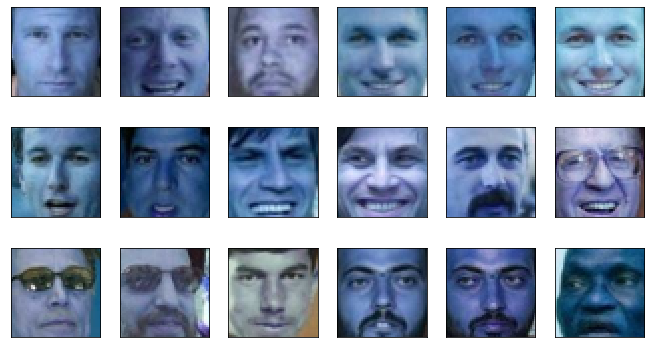

In [ ]:
plot_gallery(X_train, image_h, image_w)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [ ]:
from keras import layers, losses
from keras import initializers as init

In [ ]:
dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

In [ ]:
K.clear_session()
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([layers.Dense(units = 756, activation = 'relu'),                         
            layers.Dense(units = dimZ,activation = 'sigmoid')])
        
        self.decoder = tf.keras.Sequential([layers.Dense(units = 756, activation = 'relu'),                         
            layers.Dense(units = 6075,activation = 'sigmoid')])
    
                                            
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded                                 

autoencoder = Autoencoder()                                            

In [ ]:
# Create MSE loss function
# Use Adam optimizer
optimizer = keras.optimizers.Adam(learning_rate = 0.0005)
autoencoder.compile(optimizer=optimizer, loss=losses.MeanSquaredError())

In [ ]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay
history = autoencoder.fit(X_train, X_train, epochs = 40, 
                batch_size = 32, validation_data  = (X_val,X_val), shuffle =True)

Epoch 1/40
313/313 [==============================] - 2s 5ms/step - loss: 0.0284 - val_loss: 0.0171
Epoch 2/40
313/313 [==============================] - 2s 5ms/step - loss: 0.0162 - val_loss: 0.0124
Epoch 3/40
313/313 [==============================] - 2s 5ms/step - loss: 0.0120 - val_loss: 0.0105
Epoch 4/40
313/313 [==============================] - 2s 5ms/step - loss: 0.0103 - val_loss: 0.0097
Epoch 5/40
313/313 [==============================] - 2s 5ms/step - loss: 0.0094 - val_loss: 0.0086
Epoch 6/40
313/313 [==============================] - 2s 5ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 7/40
313/313 [==============================] - 2s 5ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 8/40
313/313 [==============================] - 2s 5ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 9/40
313/313 [==============================] - 2s 5ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 10/40
313/313 [==============================] - 2s 5ms/step - loss: 0.0069 - val_loss: 0.0067

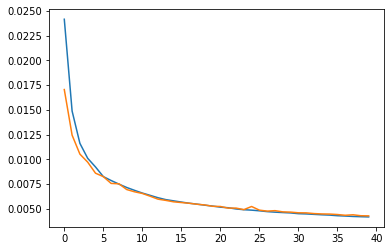

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 756)               4593456   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               75700     
Total params: 4,669,156
Trainable params: 4,669,156
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 756)               76356     
_________________________________________________________________
dense_3 (Dense)              (None, 6075)              4598775   
Total params: 4,675,131
Trainable params: 4,675,131
Non-trainable params: 0
_________________________________________________________________


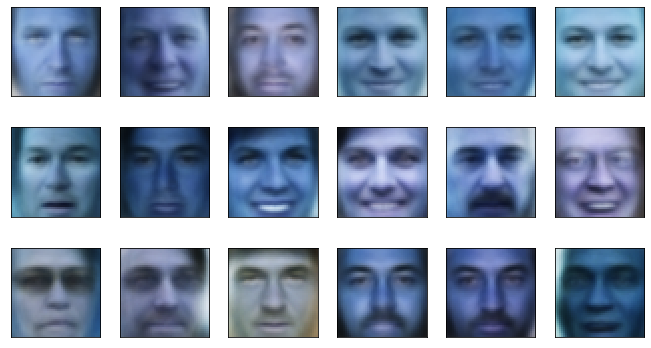

In [ ]:
encoded = autoencoder.encoder(X_train).numpy()
decoded = autoencoder.decoder(encoded).numpy()
plot_gallery(decoded, image_h, image_w)

In [ ]:
# Examine the reconstructions
encoded = autoencoder.encoder(X_val).numpy()
decoded = autoencoder.decoder(encoded).numpy()

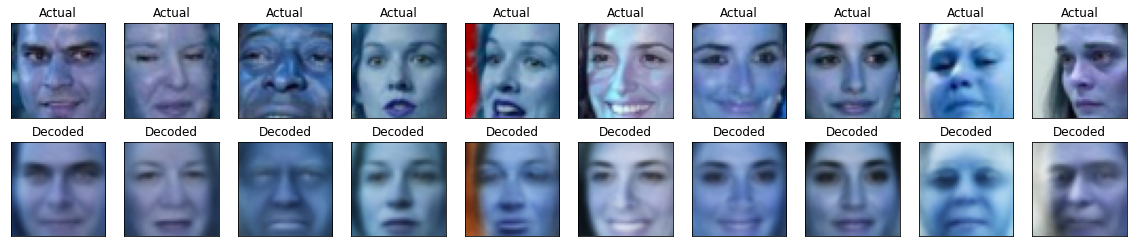

In [ ]:
plt.figure(figsize = (20,4))
for i in range(10):
    ax = plt.subplot(2,10,i + 1)
    plt.imshow(X_val[i].reshape(45,45,3))
    plt.title('Actual')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    bx = plt.subplot(2,10, i +10 + 1)
    plt.imshow(decoded[i].reshape(45,45,3))
    plt.title('Decoded')
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

Reconstruction is not bad, right? 

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

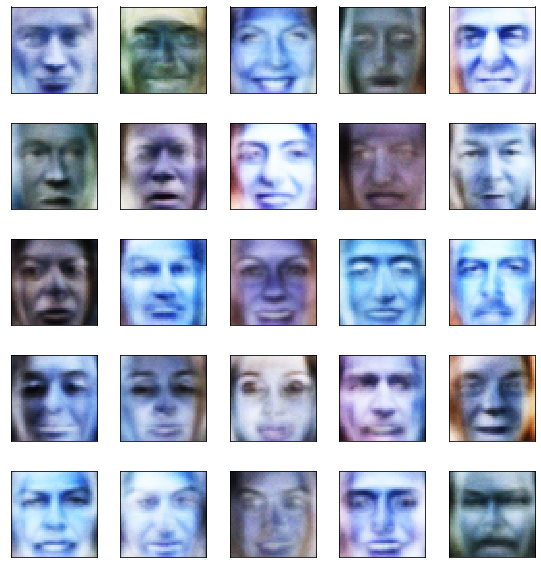

In [ ]:
z = np.random.randn(25, dimZ)*0.5
output = autoencoder.decoder(z).numpy() # FIXME compute from decoder from z
plot_gallery(output, image_h, image_w, n_row=5, n_col=5)

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler**, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [ ]:
K.clear_session()
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 2
batch_size = 50

x_input = layers.Input( (6075,))
x = layers.Dense(units = 756, activation='relu')(x_input)
x = layers.Dense(dimZ*2, activation='relu')(x)

z_mean = layers.Dense(dimZ)(x)
z_log_var = layers.Dense(dimZ)(x)

def noiser(args):
  global z_mean, z_log_var
  z_mean, z_log_var = args
  N = K.random_normal(shape = (batch_size, dimZ), mean=0., stddev=1.)
  return K.exp(z_log_var/2) * N + z_mean

z = layers.Lambda(noiser, output_shape = (dimZ,) )([z_mean, z_log_var])

decoder = layers.Input(shape= (dimZ,))
d = layers.Dense(756, activation='relu')(decoder)
decoded = layers.Dense(6075, activation='sigmoid')(d)


encoder = keras.Model(x_input,z, name = 'encoder')
decoder = keras.Model(decoder, decoded, name = 'decoder')
vae = keras.Model(x_input, decoder(encoder(x_input)), name = 'vae')


# define the network
# you can start from pytorch example https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [ ]:
def vae_loss(x,y):
  loss = K.sum(K.square(x-y), axis = -1)
  kl_loss = -0.5* K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)
  return loss +kl_loss

optimizer =keras.optimizers.Adam(learning_rate=0.0001)
vae.compile(optimizer= optimizer, loss = vae_loss)

And train the model:

In [ ]:
# train your autoencoder
history = vae.fit(X_train,X_train, 
                  batch_size=batch_size, shuffle=True, 
                  epochs=10, validation_data  = (X_val[:3100],X_val[:3100]))
# visualize progress in reconstruction and loss decay

Epoch 1/10
200/200 [==============================] - 2s 6ms/step - loss: 233.2132 - val_loss: 187.4124
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 180.7902 - val_loss: 174.2545
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 172.0503 - val_loss: 171.1192
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 169.9500 - val_loss: 169.5065
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 167.3443 - val_loss: 169.8551
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 165.7678 - val_loss: 168.5844
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 166.0823 - val_loss: 169.4495
Epoch 8/10
200/200 [==============================] - 1s 5ms/step - loss: 166.0653 - val_loss: 166.6963
Epoch 9/10
200/200 [==============================] - 1s 5ms/step - loss: 164.5290 - val_loss: 165.6420
Epoch 10/10
200/200 [==============================] - 1s 5ms/st

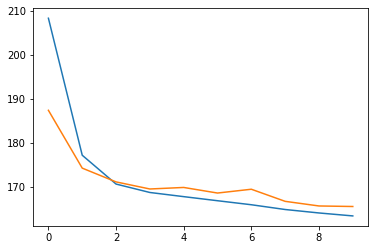

In [ ]:
# test your autoencoder with validation data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

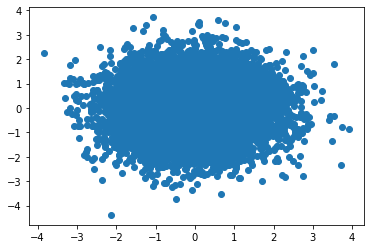

In [ ]:
z = encoder.predict(X_train, batch_size=batch_size)
plt.scatter(z[:,0], z[:,1])

And finally sample from VAE.

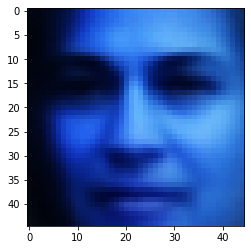

In [ ]:
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))
plt.imshow(decoder.predict(np.expand_dims([20,6], axis = 0)).reshape(45,45,3))

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

In [ ]:
smile = attrs[attrs.Smiling > 0.95].index[:10]
non_smile = attrs[attrs.Smiling < -0.95].index[:10]

In [ ]:
smile

Int64Index([5, 8, 9, 11, 26, 34, 60, 83, 88, 96], dtype='int64')

In [ ]:
vector_smile = np.mean([autoencoder.encoder(i.reshape(1,6075))[0] for i in data[smile]], axis = 0)
vector_non_smile = np.mean([autoencoder.encoder(i.reshape(1,6075))[0] for i in data[non_smile]], axis = 0)

In [ ]:
diff = vector_smile - vector_non_smile

In [ ]:
rand = np.random.choice(attrs[attrs.Smiling < -0.95].index)

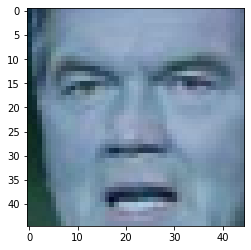

In [ ]:
plt.imshow(data[rand])

In [ ]:
latent = autoencoder.encoder(data[rand].reshape(1,6075))

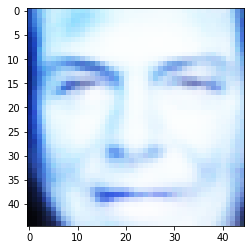

In [ ]:
plt.imshow(autoencoder.decoder(latent).numpy().reshape(45,45,3))

<img src="linear.png" alt="linear">